# Stroke Prediction: A Binary Classification Problem

In this notebook, I will work on a supervised binary classification problem to predict whether a subject is a stroke patient or not. In order to do so, I will leverage three models: one linear model (Logistic Regression) and two non-linear ones (Neural Network and Random Forest).

I will engage in the following steps, chronologically:

1. [Setup: Importing Libraries and Data](#1)
2. [Exploratory Data Analysis (EDA)](#2)
3. [Data Preprocessing](#3)
4. [Feature Engineering & Selection](#4)
5. [Model Selection](#5)
6. [Model Evaluation](#6)
7. [Conclusion](#7)


## Setup: Importing Libraries and Data <a id="1"></a>

First: import all necessary dependencies.


In [233]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))


import numpy as np
import sklearn
import torch
from loguru import logger
import pandas as pd

from src.data_preparation import load_data, min_max_normalize, StrokeDataset, replace_na, transform_non_numericals, split_X_y, create_polynomials, transform_polynomials, create_pca, transform_pca
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from src.training import BinaryLogisticRegression, BinaryNeuralNetwork, NaiveBaseline, evaluate, weighted_binary_cross_entropy_loss, k_fold_cross_validation, feature_selection, select_model
from src.data_understanding import plot_distributions, print_na, print_non_numericals, plot_scatter_and_pair, plot_relative_distributions
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In order to optimize training times, let's use the best available device, leveraging the machine's physical resources.


In [234]:
# setting parallel inference method
device = None
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using MPS


In [235]:
# set seeds for sklearn, numpy, pandas

seed = 42
random.seed(seed)
np.random.seed(seed)

## Exploratory Data Analysis (EDA) <a id="2"></a>


### Data Exploration

By creating a first graphical representation of the data at hand, we can understand the underlying distributions.


In [236]:
# load data
path_data_train = "data/train.csv"
path_data_test = "data/test.csv"

data_train_raw = load_data(base_path / path_data_train)
data_test_raw = load_data(base_path / path_data_test)

data_train_raw.drop(columns=["id"], inplace=True)
test_ids = data_test_raw["id"]
data_test_raw.drop(columns=["id"], inplace=True)

2024-07-31 17:20:47.391 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.

2024-07-31 17:20:47.395 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.



Let's plot the distributions of the raw data to get an initial understanding of what we are working with.


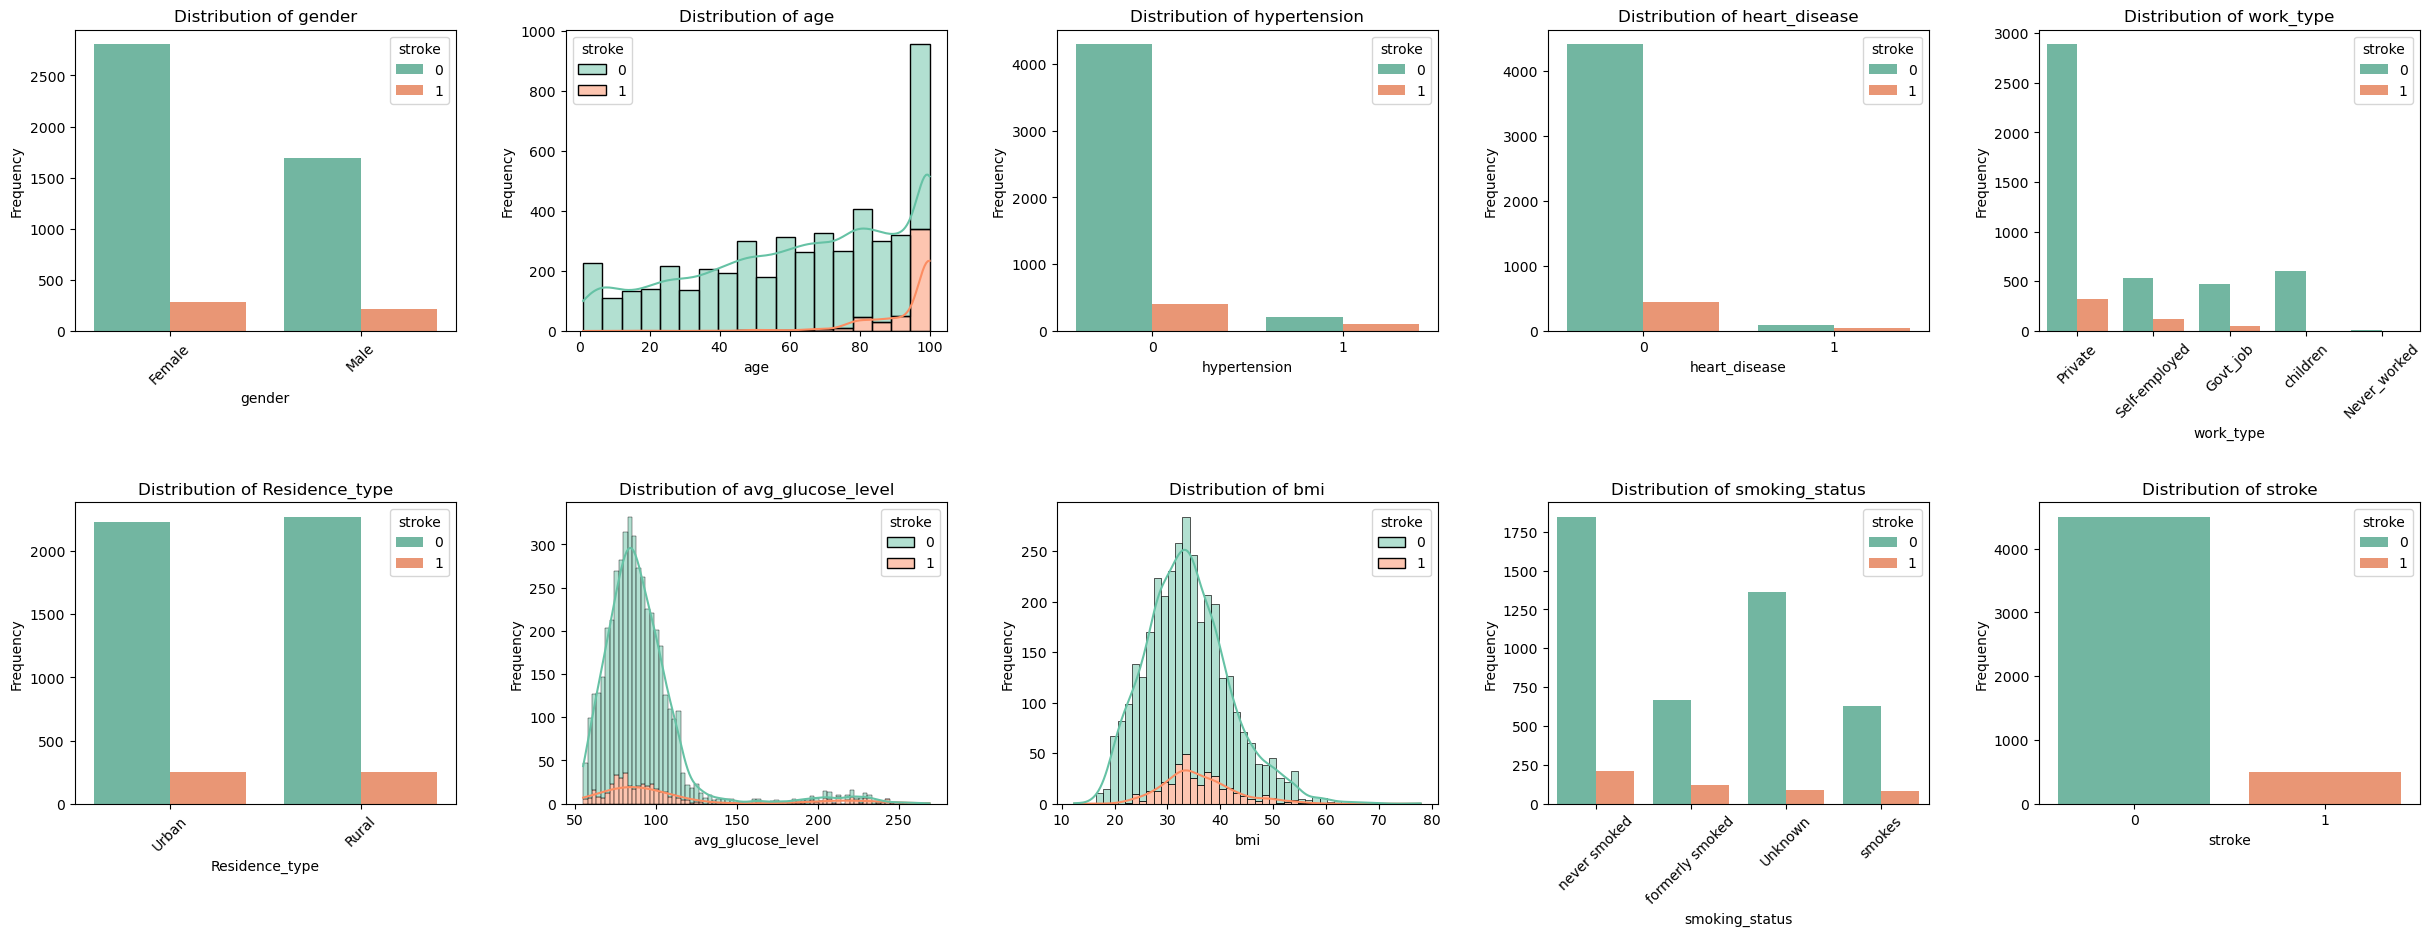

In [237]:
plot_distributions(data_train_raw)

Some important first insights:

-   The dataset is highly imbalanced: There are many more instances of people who did not have a stroke than those who did. This will require special attention during model training and evaluation.
-   We have a mix of numerical and categorical features. We will need to preprocess them accordingly.
-   Regarding the numerical features:
    -   The features have different scales. We will normalize them.
-   Regarding the categorical features:
    -   Some categorical features are binary, while others have more than two values.
    -   The categorical features with more than two values are nominal, i.e., there is no inherent order in the categories. We will one-hot encode them.
        -   Note: The `smoking_status` feature could be interpreted as ordinal in some sense ("time since last cigarette"), however, the influence of this underlying order on the target variable is not clear. We will treat it as a nominal feature.


To make sure that the training and test data come from the same underlying distribution, let's plot the test data as well.


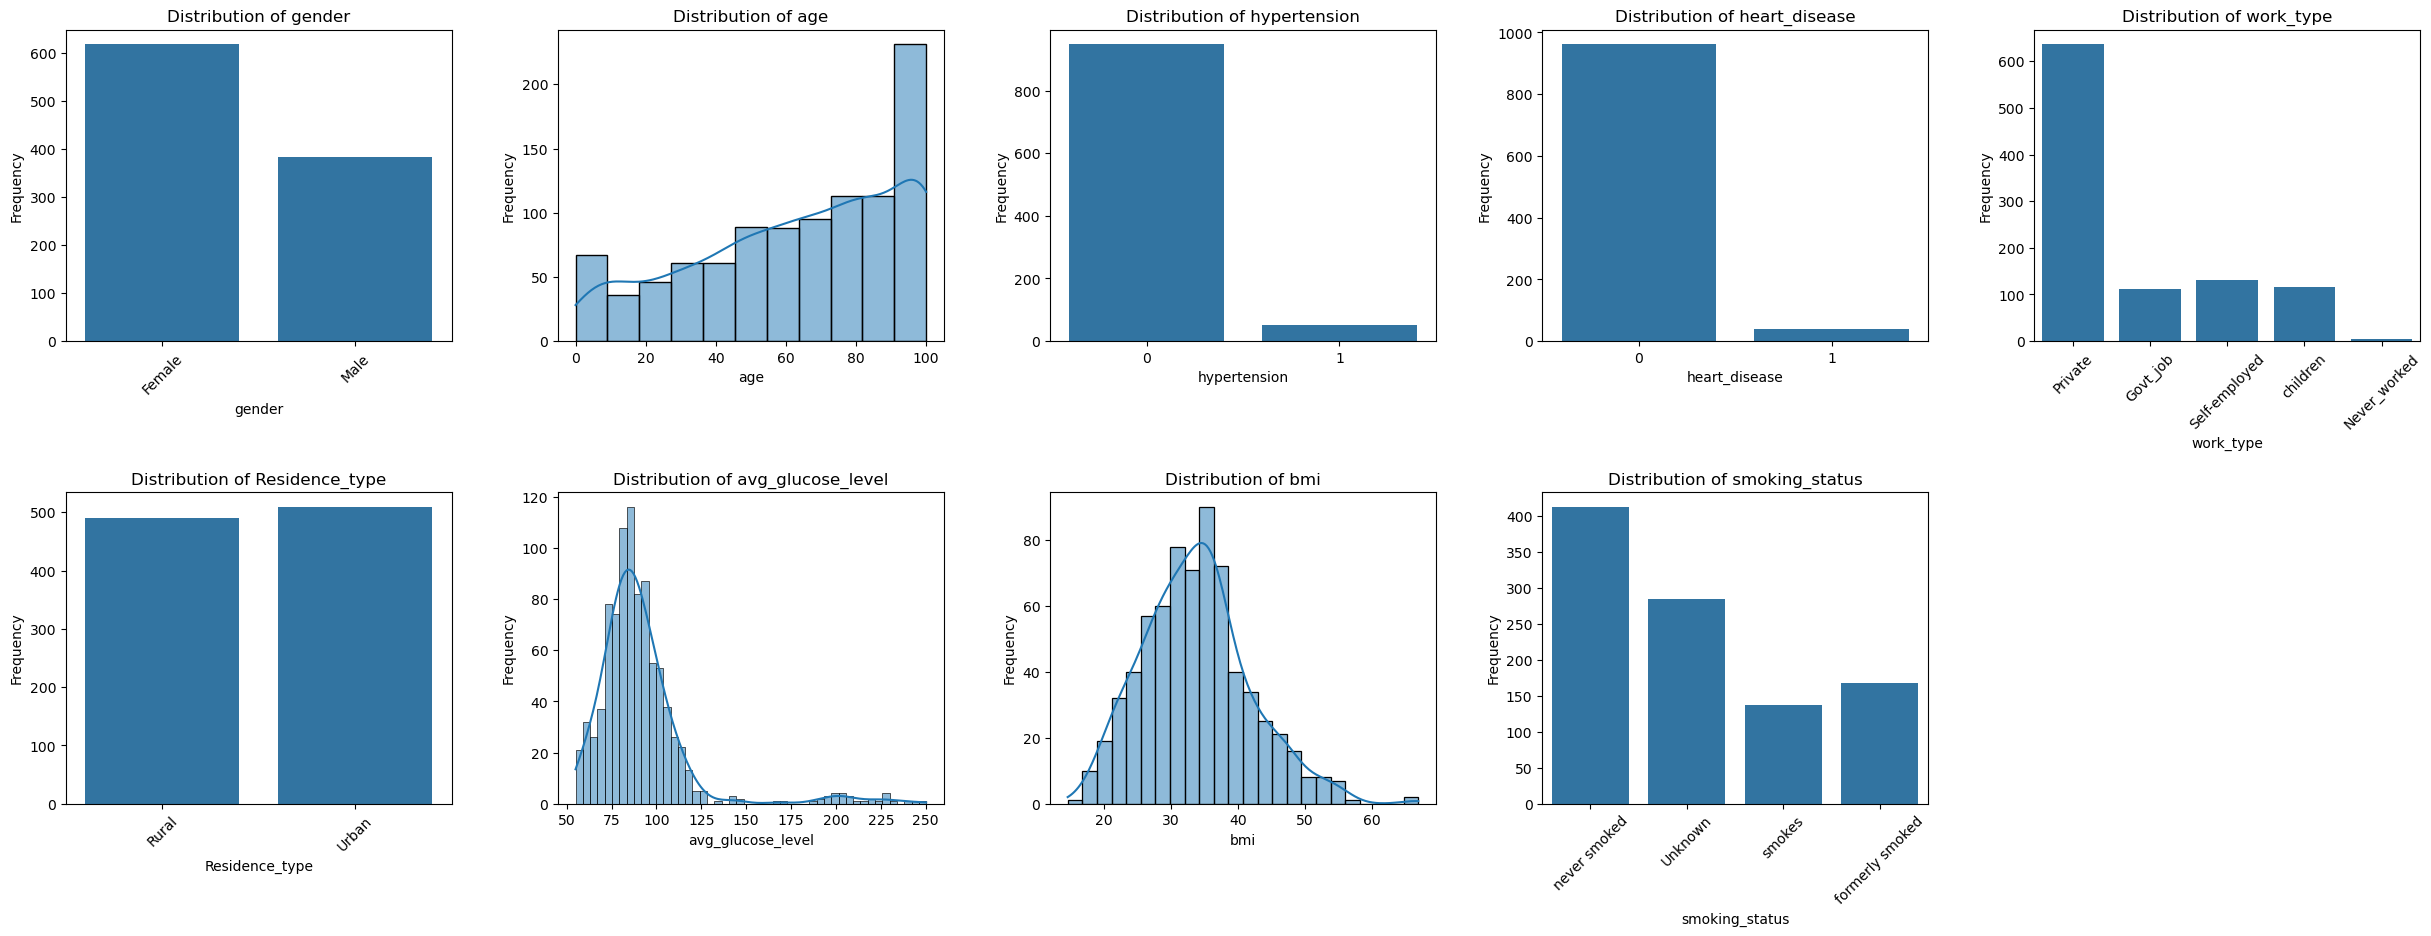

In [238]:
plot_distributions(data_test_raw)

Looking good: No significant covariate shift is apparent. The distribution of some features, such as `smoking_status` and `work_type`, may differ slightly between the training and test data, but it seems more likely our relatively small sample size creates this illusion.

Next, I'll have a look at the relative distributions of the target variable `stroke` over the features of the training data.


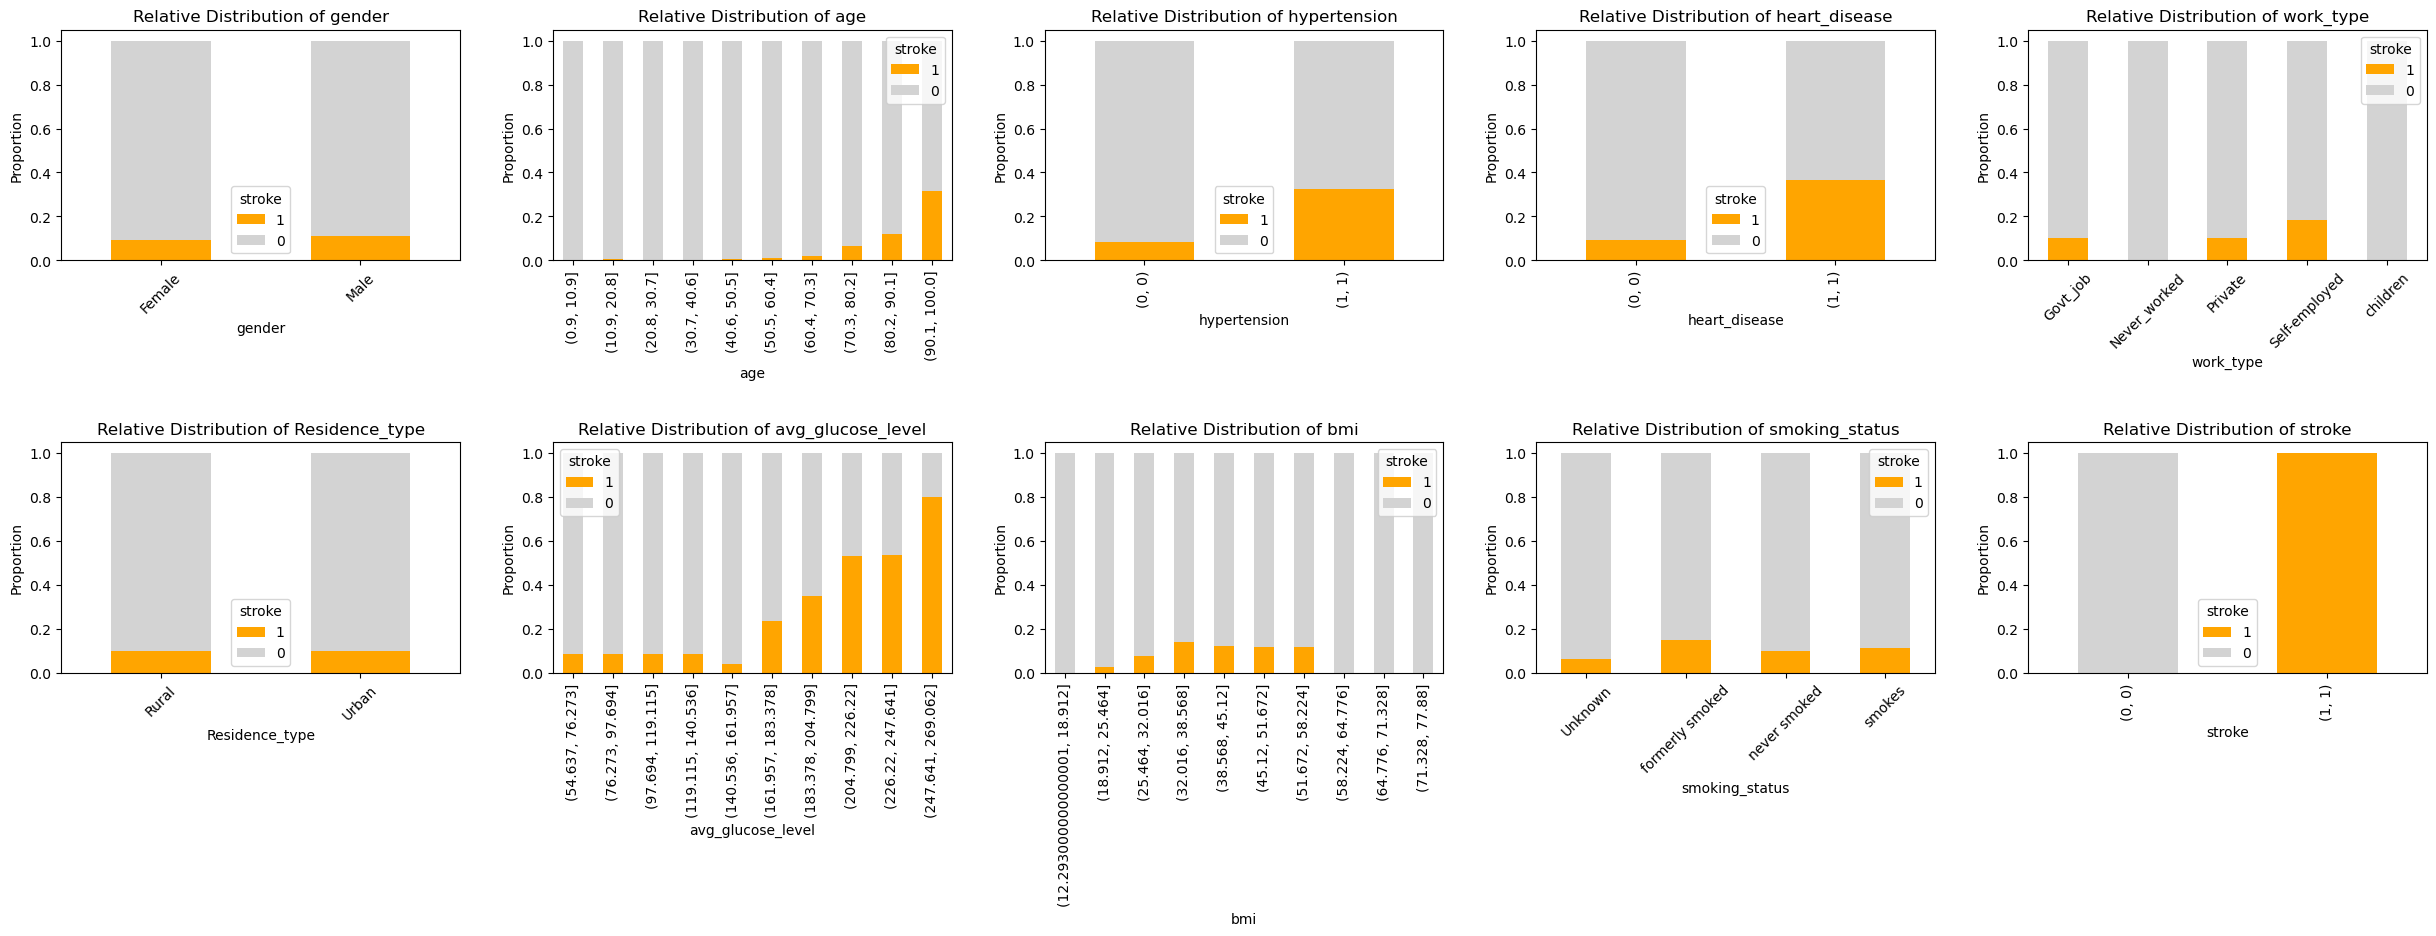

In [239]:
plot_relative_distributions(data_train_raw)

Some more important insights:

-   Regarding the continuous features:
    -   The influence of `age` and `bmi` on the likelihood of `stroke` seems to be positive and may be non-linear.
    -   `avg_glucose_level` might have a positive linear influence on the target variable, starting at a certain threshold.
-   Regarding the categorical features:
    -   `hypertension` and `heart_disease` seem to have a significant positive influence on the target variable.
    -   `work_type`: People who are self-employed seem to have a slightly higher chance of having a stroke. People who never worked or care for their children have a lower chance. Government workers and private workers seem to have a similar distribution.
    -   Both `gender` and `Residence_type` seem to have no significant influence on the target variable in isolation. However, there might be interaction effects with other features.

These are just first impressions. We did not test significance. Furthermore, we only yet looked at the features and their potential relationships with the target variable in isolation. By analyzing interaction effects later, we can get a more accurate understanding of the data and create better features for our models, which is especially important for the logistic regression model, given its linear nature.


In [240]:
print_na(data_train_raw)
print_non_numericals(data_train_raw)

2024-07-31 17:20:50.051 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column gender: 0 / 5000
2024-07-31 17:20:50.052 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column age: 0 / 5000
2024-07-31 17:20:50.052 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column hypertension: 0 / 5000
2024-07-31 17:20:50.053 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column heart_disease: 0 / 5000
2024-07-31 17:20:50.053 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column work_type: 0 / 5000
2024-07-31 17:20:50.054 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column Residence_type: 0 / 5000
2024-07-31 17:20:50.055 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column avg_glucose_leve

We can see there are a lot of missing values in our training data: 2756 / 5000 data points have at least one missing value. We will need to address this issue in the preprocessing step. Since there are so many data points with missing values, we will not simply drop those.

-   For the continuous features `avg_glucose_level` and `bmi`, we will impute the missing values with the median of the respective feature.
-   For the categorical feature `smoking_status`, the missing values currently make up a separate category called "Unknown". We will treat this category as a separate category in the one-hot encoding step.


## Data Preprocessing <a id="3"></a>


In this section, we will preprocess the data to prepare it for model training. We will:

-   Transform non-numerical features into numerical ones. This is done using one-hot encoding.
-   Replace missing values in the continuous features with the median of that respective feature.
-   Normalize the numerical features using min-max normalization. This way, all features will have the same scale, which also avoids gradient problems during neural network training.


In [241]:
data_train_preprocessed = transform_non_numericals(data_train_raw)
data_train_preprocessed = replace_na(data_train_preprocessed, replace_with="median")
data_train_preprocessed = min_max_normalize(data_train_preprocessed)

data_test_preprocessed = transform_non_numericals(data_test_raw)
data_test_preprocessed = replace_na(data_test_preprocessed, replace_with="median")
data_test_preprocessed = min_max_normalize(data_test_preprocessed)

X_original = data_train_preprocessed.drop(columns=["stroke"]).copy().to_numpy()
y_original = data_train_preprocessed["stroke"].copy().to_numpy()
X_test_original = data_test_preprocessed.copy().to_numpy()

X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(
    X_original, y_original, test_size=0.2
)

2024-07-31 17:20:50.081 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed gender into binary encoding
2024-07-31 17:20:50.083 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:53 - Transformed work_type into one-hot encoding
2024-07-31 17:20:50.083 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed Residence_type into binary encoding
2024-07-31 17:20:50.085 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:53 - Transformed smoking_status into one-hot encoding
2024-07-31 17:20:50.086 | INFO     | src.data_preparation.data_preprocessing:replace_na:36 - Replaced NaN values with median
2024-07-31 17:20:50.089 | INFO     | src.data_preparation.data_preprocessing:min_max_normalize:69 - Normalized data using min-max normalization
2024-07-31 17:20:50.089 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed gen

## Feature Engineering & Selection <a id="4"></a>


Next, we will create new features by combining existing ones, using polynomials and Principal Component Analysis (PCA). This way, we can map non linear-relationships between the features and the target to linear relationships, which is especially important to improve the performance of the logistic regression model.

After creating the new features, we will do some feature selection to reduce the dimensionality of the feature space. This will help avoid overfitting and reduce training times. We will then be left with the most important features, including the originals and the engineered ones.

Finally, we will plot the distribution of these residing features in relation to the target variable `stroke`, to see if the new features reveal important relationships to the target variable. We will also plot these residing features in a pair plot with the target variable to see if we can identify interaction patterns.


### Feature Engineering: Polynomial Features


We are going to create polynomial features of degree 2. This means: For each pair of features, we will create a new feature that is the product of the two features.
Example: Given features $x_1$ and $x_2$, we will end up with the following features: $x_1$, $x_2$, $x_1 x_2$, $x_1^2$, and $x_2^2$.


In [242]:
d_poly = 2

# feature cols without target
feature_columns = data_train_preprocessed.columns.drop("stroke")

polynomials_train, feature_names = create_polynomials(
    data_train_preprocessed, feature_columns, degree=d_poly
)
print(f"Features in polynomial_train: {polynomials_train.columns}")
polynomials_test = transform_polynomials(data_test_preprocessed, feature_names)

logger.info(f"Data preprocessed train shape: {data_train_preprocessed.shape}")
logger.info(f"Data preprocessed test shape: {data_test_preprocessed.shape}")
logger.info(f"Polynomials train shape: {polynomials_train.shape}")
logger.info(f"Polynomials test shape: {polynomials_test.shape}")

2024-07-31 17:20:50.277 | INFO     | __main__:<module>:12 - Data preprocessed train shape: (5000, 17)
2024-07-31 17:20:50.277 | INFO     | __main__:<module>:13 - Data preprocessed test shape: (1000, 16)
2024-07-31 17:20:50.278 | INFO     | __main__:<module>:14 - Polynomials train shape: (5000, 153)
2024-07-31 17:20:50.278 | INFO     | __main__:<module>:15 - Polynomials test shape: (1000, 152)


Features in polynomial_train: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'work_type_Govt_job',
       'work_type_Never_worked',
       ...
       'smoking_status_Unknown^smoking_status_Unknown',
       'smoking_status_Unknown^smoking_status_formerly smoked',
       'smoking_status_Unknown^smoking_status_never smoked',
       'smoking_status_Unknown^smoking_status_smokes',
       'smoking_status_formerly smoked^smoking_status_formerly smoked',
       'smoking_status_formerly smoked^smoking_status_never smoked',
       'smoking_status_formerly smoked^smoking_status_smokes',
       'smoking_status_never smoked^smoking_status_never smoked',
       'smoking_status_never smoked^smoking_status_smokes',
       'smoking_status_smokes^smoking_status_smokes'],
      dtype='object', length=153)


We can see that we got quite a lot more features! Those are clearly too many to include (even too many to plot!). After applying Principal Component Analysis (PCA) in the next step, we will reduce the dimensionality of the feature space. In order to avoid the "Qual der Wahl" (the agony of choice), we will simply let the Logistic Regression model decide which features are important.


In [243]:
n_pcs = 8

pcs_train, pca = create_pca(polynomials_train, feature_columns, n_components=n_pcs)
pcs_test = transform_pca(polynomials_test, pca, feature_columns)

logger.info(f"Principal components train shape: {pcs_train.shape}")
logger.info(f"Principal components test shape: {pcs_test.shape}")

2024-07-31 17:20:50.322 | INFO     | __main__:<module>:6 - Principal components train shape: (5000, 8)
2024-07-31 17:20:50.323 | INFO     | __main__:<module>:7 - Principal components test shape: (1000, 8)


In order to train our Logistic Regression model on all these new features, we will need to group them together with the original features.


In [244]:
data_train_tmp = pd.concat([polynomials_train, pcs_train], axis=1)
data_test_tmp = pd.concat([polynomials_test, pcs_test], axis=1)

feature_names_tmp = data_train_tmp.drop(columns=["stroke"]).columns.to_list()

X_tmp = data_train_tmp.drop(columns=["stroke"]).copy().to_numpy()
y_tmp = data_train_tmp["stroke"].copy().to_numpy()
X_test_tmp = data_test_tmp.copy().to_numpy()

logger.info(f"First ten features in data_train_tmp: {feature_names_tmp[0:10]}")
logger.info(f"Last ten features in data_train_tmp: {feature_names_tmp[-10:]}")
logger.info(f"First ten features in data_test_tmp: {data_test_tmp.columns[0:10]}")
logger.info(f"Last ten features in data_test_tmp: {data_test_tmp.columns[-10:]}")

2024-07-31 17:20:50.380 | INFO     | __main__:<module>:10 - First ten features in data_train_tmp: ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private']
2024-07-31 17:20:50.384 | INFO     | __main__:<module>:11 - Last ten features in data_train_tmp: ['smoking_status_never smoked^smoking_status_smokes', 'smoking_status_smokes^smoking_status_smokes', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
2024-07-31 17:20:50.384 | INFO     | __main__:<module>:12 - First ten features in data_test_tmp: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private'],
      dtype='object')
2024-07-31 17:20:50.385 | INFO     | __main__:<module>:13 - Last ten features in data_test_tmp: Index(['smoking_status_never smoked^smoking_status_smokes',
       'smoking_stat

### Feature Selection


To select the most important features, we will train our Logistic Regression model with L1 regularization, effectively forcing competition between features, leading to the model setting many features' weights to 0, then drop the features with the weakest weights.


i = 0 / 159 – Empirical Risk Estimate: 0.23020385428527423, Previous Estimate: inf – new number of features to delete – new lowest risk estimate
i = 5 / 159 – Empirical Risk Estimate: 0.22993819360601905, Previous Estimate: 0.23020385428527423 – new number of features to delete – new lowest risk estimate
i = 10 / 159 – Empirical Risk Estimate: 0.22993474517152607, Previous Estimate: 0.22993819360601905 – new number of features to delete – new lowest risk estimate
i = 15 / 159 – Empirical Risk Estimate: 0.22993600590805027, Previous Estimate: 0.22993474517152607
i = 20 / 159 – Empirical Risk Estimate: 0.22993537292902827, Previous Estimate: 0.22993600590805027
i = 25 / 159 – Empirical Risk Estimate: 0.22993239841864765, Previous Estimate: 0.22993537292902827 – new number of features to delete – new lowest risk estimate
i = 30 / 159 – Empirical Risk Estimate: 0.2299327963143456, Previous Estimate: 0.22993239841864765
i = 35 / 159 – Empirical Risk Estimate: 0.22993456803830284, Previous E

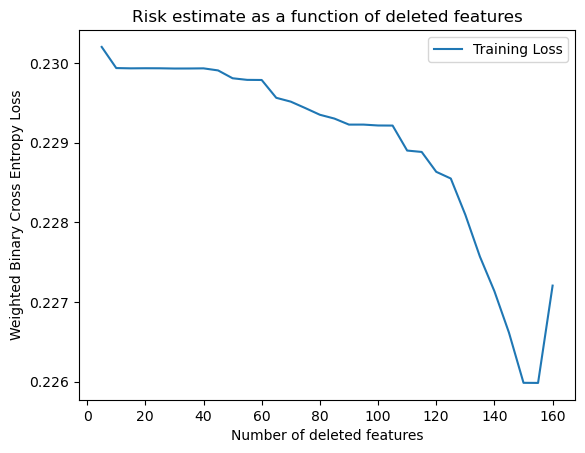

Features to delete (150, thereof unique 150): [0, 116, 115, 113, 111, 1, 117, 110, 109, 108, 2, 119, 118, 107, 105, 3, 104, 103, 102, 101, 4, 121, 120, 99, 98, 5, 122, 97, 96, 95, 6, 124, 123, 92, 91, 7, 126, 125, 90, 89, 8, 127, 88, 87, 84, 66, 131, 129, 81, 79, 63, 132, 78, 76, 74, 61, 134, 133, 71, 70, 159, 43, 44, 45, 46, 158, 47, 151, 49, 137, 52, 41, 42, 50, 149, 62, 38, 39, 150, 147, 55, 37, 152, 148, 53, 64, 33, 34, 145, 144, 138, 65, 69, 57, 56, 146, 139, 140, 141, 142, 30, 135, 136, 36, 143, 23, 68, 27, 153, 24, 10, 11, 12, 13, 14, 67, 15, 16, 18, 154, 73, 20, 114, 156, 25, 106, 58, 19, 35, 83, 17, 128, 28, 31, 29, 130, 82, 85, 9, 80, 75, 22, 94, 48, 21, 155, 59, 100, 54, 77]


In [245]:
n_features_per_iteration = 5  # delete 5 features per iteration
risk_estimate_error_margin = 0.00  # metric: weighted binary cross entropy loss

features_to_delete, risk_estimates = feature_selection(
    X_tmp,
    y_tmp,
    n_features_per_iteration=n_features_per_iteration,
    risk_estimate_error_margin=risk_estimate_error_margin,
    plot=True,
)
print(
    f"Features to delete ({len(features_to_delete)}, thereof unique {len(set(features_to_delete))}): {features_to_delete}"
)

Let's create new references `X_train_selected`, `X_val_selected` and `X_test_selected`.


In [256]:
# drop the features
logger.info(f"Shape of X_tmp before feature selection: {X_tmp.shape}")
logger.info(f"Shape of X_test_selected before feature selection: {X_test_tmp.shape}")

X_selected = np.delete(X_tmp, features_to_delete, axis=1)
y_selected = y_tmp
X_test_selected = np.delete(X_test_tmp, features_to_delete, axis=1)

X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(
    X_selected, y_selected, test_size=0.2
)

logger.info(
    f"Shape of X_train_selected after feature selection: {X_train_selected.shape}"
)
logger.info(f"Shape of X_val_selected after feature selection: {X_val_selected.shape}")
logger.info(
    f"Shape of X_test_selected after feature selection: {X_test_selected.shape}"
)

2024-07-31 17:36:48.206 | INFO     | __main__:<module>:2 - Shape of X_tmp before feature selection: (5000, 160)
2024-07-31 17:36:48.208 | INFO     | __main__:<module>:3 - Shape of X_test_selected before feature selection: (1000, 160)
2024-07-31 17:36:48.210 | INFO     | __main__:<module>:13 - Shape of X_train_selected after feature selection: (4000, 10)
2024-07-31 17:36:48.211 | INFO     | __main__:<module>:16 - Shape of X_val_selected after feature selection: (1000, 10)
2024-07-31 17:36:48.212 | INFO     | __main__:<module>:17 - Shape of X_test_selected after feature selection: (1000, 10)


## Model Selection <a id="5"></a>


We arrive at the most fun part of this notebook: the model training and evaluation. For each model, we will first train the model on a manually selected set of hyperparameters and plot the learning curves and Receiver Operator Characteristic (ROC). After that, we will use nested cross-validation to optimize the hyperparameters for the model.

One exception: We will start with the baseline model, our Naive implementation. Here, no real fit is required. Each prediction is as likely to be positive as the probability of a positive class in the training data. We will use this as a baseline to compare our models against.


### Naive Baseline


2024-07-31 17:22:13.397 | INFO     | src.training.evaluate:evaluate:46 - Naive Baseline – Empirical Risk Estimate: 1.195183838188902, Accuracy: 0.833, F1 score: 0.08743169398907104, Precision: 0.08602150537634409, Recall: 0.08888888888888889, AUC: 0.5
            Pred Neg  Pred Pos
Actual Neg       825        85
Actual Pos        82         8


Validation accuracy: 0.827


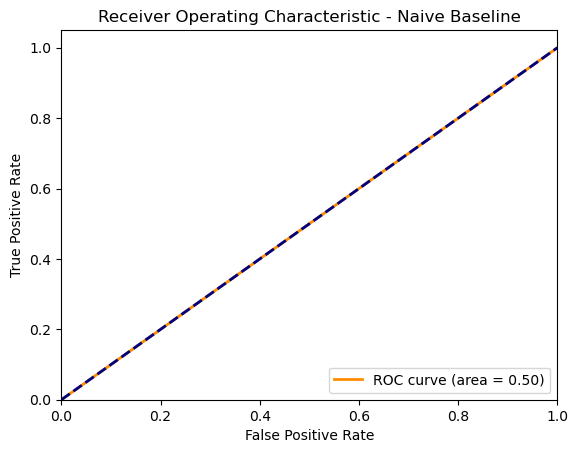

(1.195183838188902, 0.833, 0.08743169398907104, 0.5)

In [247]:
# Naive Baseline
naive_baseline = NaiveBaseline()
naive_baseline.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected)
y_pred = naive_baseline.predict(X_val_selected)
y_pred_proba = naive_baseline.predict_proba(X_val_selected)
evaluate("Naive Baseline", y_val_selected, y_pred, y_pred_proba, plot=True)

The results here match expectations: The Naive Model has an Area Under the Curve (AUC) of 0.5, which means it is as good as random: The probability that a randomly positive instance gets higher output score than a randomly drawn negative instance is 50%.

Also, recall and precision are pretty low, which is expected given the random guesses of the model. The accucary is relatively high, which is simply due to the fact that the dataset is highly imbalanced: more samples are negative, so the model will predict negative more often, which results in high accuracy.

Next, we will train the Logistic Regression model on the selected features.


## Logistic Regression


### Setting Hyperparameters Manually


In [248]:
epochs = 20
learning_rate = 0.01
batch_size = 8
lambda_reg = 0.01

Epoch 0: Train Loss: 0.6674619611091633, Val Loss: 0.6136631748736179
Epoch 1: Train Loss: 0.6309519927938003, Val Loss: 0.5815668354069121
Epoch 2: Train Loss: 0.6036678191846464, Val Loss: 0.5560660668710723
Epoch 3: Train Loss: 0.582089325554226, Val Loss: 0.5356887083515365
Epoch 4: Train Loss: 0.5647813519600317, Val Loss: 0.5192273458694154
Epoch 5: Train Loss: 0.5507323545983576, Val Loss: 0.5057798229224941
Epoch 6: Train Loss: 0.539202360551288, Val Loss: 0.494677913024627
Epoch 7: Train Loss: 0.5296433300140314, Val Loss: 0.4854230636766175
Epoch 8: Train Loss: 0.5216448102158832, Val Loss: 0.47763937736048967
Epoch 9: Train Loss: 0.5148957960987167, Val Loss: 0.47104020772234945
Epoch 10: Train Loss: 0.509157851517037, Val Loss: 0.4654044750145356
Epoch 11: Train Loss: 0.5042460673830583, Val Loss: 0.4605597804819331
Epoch 12: Train Loss: 0.5000154634078241, Val Loss: 0.45637026538864545
Epoch 13: Train Loss: 0.49635118170460435, Val Loss: 0.45272779518929435
Epoch 14: Train

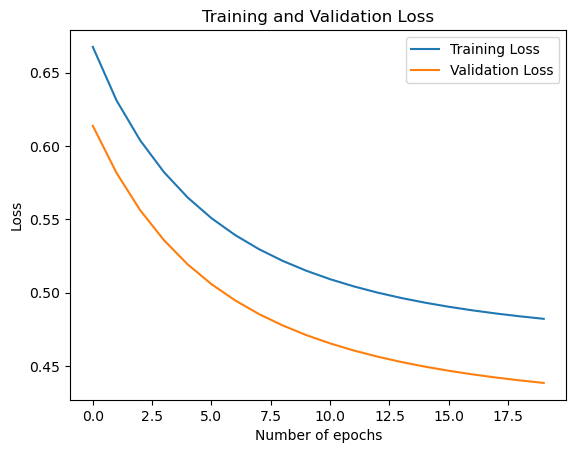

2024-07-31 17:22:14.039 | INFO     | src.training.evaluate:evaluate:46 - Logistic Regression – Empirical Risk Estimate: 0.4611065829706061, Accuracy: 0.751, F1 score: 0.3882063882063882, Precision: 0.24921135646687698, Recall: 0.8777777777777778, AUC: 0.8933577533577534
            Pred Neg  Pred Pos
Actual Neg       672       238
Actual Pos        11        79


Training complete.


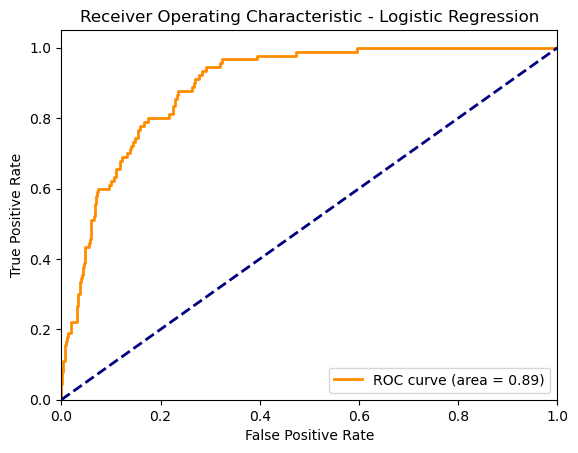

In [249]:
# Logisic Regression Hyper Param Tuning
lr = BinaryLogisticRegression(
    X_train_selected.shape[1],
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)

lr.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected, plot=True)

y_pred = lr.predict(X_val_selected)
y_pred_proba = lr.predict_proba(X_val_selected)
R_est, acc, f1, auc = evaluate(
    "Logistic Regression", y_val_selected, y_pred, y_pred_proba, plot=True
)

We can see that the model learns! We get an AUC of around 0.88 on the validation set, which is a good start. 

Judging from the correlation matrix, we can see that the model leans towards positive predictions, which makes sense given the penalty weights we used to counteract the imbalanced dataset. This is also reflected by the relatively low precision and high recall.

We will try varying the hyperparameters to see if we can improve model performance further. Instead of manually looking for a best set of hyperparameters, we will use the select_model function to find the best hyperparameters for us.


### Automatic Hyperparameter Tuning


In [259]:
param_grid_lr = {
    "n_features": [X_train_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.1, 0.01, 0.001],
}

Empirical risk estimate for fold 1 / 5, parameter set 1 / 27: 0.5972495550892238
Empirical risk estimate for fold 1 / 5, parameter set 2 / 27: 0.46763538208660915
Empirical risk estimate for fold 1 / 5, parameter set 3 / 27: 0.4348825532762177
Empirical risk estimate for fold 1 / 5, parameter set 4 / 27: 0.5940216923233093
Empirical risk estimate for fold 1 / 5, parameter set 5 / 27: 0.4735783805784424
Empirical risk estimate for fold 1 / 5, parameter set 6 / 27: 0.444621060694036
Empirical risk estimate for fold 1 / 5, parameter set 7 / 27: 0.600941236775913
Empirical risk estimate for fold 1 / 5, parameter set 8 / 27: 0.5432098807584669
Empirical risk estimate for fold 1 / 5, parameter set 9 / 27: 0.5318463186523676
Empirical risk estimate for fold 1 / 5, parameter set 10 / 27: 0.5987072934611993
Empirical risk estimate for fold 1 / 5, parameter set 11 / 27: 0.46492041099724707
Empirical risk estimate for fold 1 / 5, parameter set 12 / 27: 0.43128686311978204
Empirical risk estimate 

2024-07-31 18:04:01.273 | INFO     | src.training.evaluate:evaluate:46 - Binary Logistic Regression – Empirical Risk Estimate: 0.4044604078247168, Accuracy: 0.7425, F1 score: 0.39766081871345027, Precision: 0.25757575757575757, Recall: 0.8717948717948718, AUC: 0.8991050500745792
            Pred Neg  Pred Pos
Actual Neg       526       196
Actual Pos        10        68


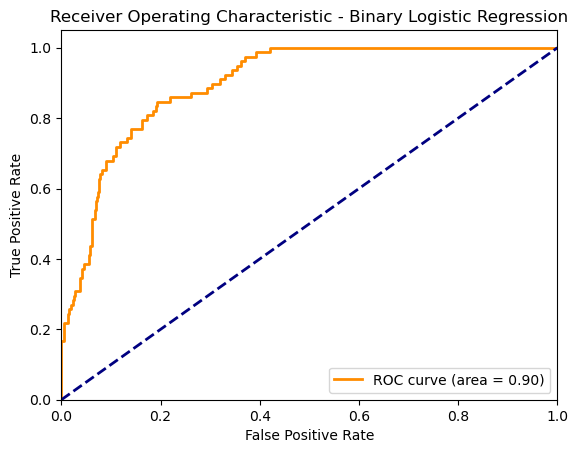

Empirical risk estimate on outer validation set: 0.4044604078247168
Epoch 0: Train Loss: 0.5684720209979631, Val Loss: 0.4996820073107542
Epoch 1: Train Loss: 0.47979185562060006, Val Loss: 0.4618647219182105
Epoch 2: Train Loss: 0.45716636078799955, Val Loss: 0.4486817129064352
Epoch 3: Train Loss: 0.4482914790197403, Val Loss: 0.4427101706640899
Epoch 4: Train Loss: 0.4439884132909401, Val Loss: 0.43954787286562474
Epoch 5: Train Loss: 0.4416062783350998, Val Loss: 0.4376840959220651
Epoch 6: Train Loss: 0.44015844755407485, Val Loss: 0.4364959046581705
Epoch 7: Train Loss: 0.4392151076262286, Val Loss: 0.43569210016040283
Epoch 8: Train Loss: 0.438567024704524, Val Loss: 0.4351230531950695
Epoch 9: Train Loss: 0.4381032088821923, Val Loss: 0.4347057817306301
Epoch 10: Train Loss: 0.43776049431809355, Val Loss: 0.43439123529823814
Epoch 11: Train Loss: 0.43750074651783516, Val Loss: 0.4341488201912218
Epoch 12: Train Loss: 0.4372997724194512, Val Loss: 0.43395857779231334
Epoch 13: T

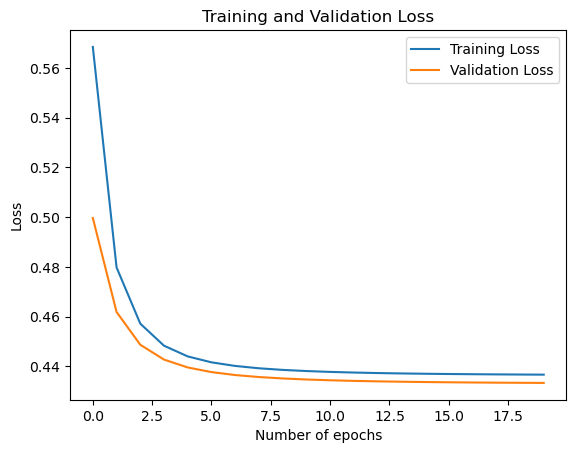

Training complete.
Fitted final model on entire dataset


In [260]:
k = 5

lr_final, lr_params, lr_R_est, lr_acc, lr_f1, lr_auc = select_model(
    X_train_selected,
    y_train_selected,
    BinaryLogisticRegression,
    param_grid_lr,
    k=k,
)

Okay! We actually managed to find a model that is pretty good at linearly seperating the data.

The AUC is > 0.999, which is a great result. It means that given a randomly chosen positive instance will get a higher output score than a randomly chosen negative instance in 99.9% of the cases.

The precision is around 0.98, which is strong, especially given the imbalance in the dataset. It means that 98% of the positive predictions are actually positive.

The recall is around 0.98, which is also strong. It means the model is able to correctly classify 98 % of positive cases.

Let's do the same model selection and evaluation process for the Neural Network next.


## Neural Network


### Setting Hyperparameters Manually


In [261]:
epochs = 20
d_hidden = 32
n_hidden = 1
learning_rate = 0.001
batch_size = 3
lambda_reg = 0.001

Epoch 0: Train Loss: 0.6994227736659048, Val Loss: 0.6421109659076444
Epoch 1: Train Loss: 0.6688619911802967, Val Loss: 0.6214475498716324
Epoch 2: Train Loss: 0.6472342193251789, Val Loss: 0.5999906567741377
Epoch 3: Train Loss: 0.6261077844396481, Val Loss: 0.5786497433709469
Epoch 4: Train Loss: 0.605279356574353, Val Loss: 0.5575803284069963
Epoch 5: Train Loss: 0.585101962223386, Val Loss: 0.5370942525821939
Epoch 6: Train Loss: 0.5657173572446241, Val Loss: 0.5174068992741272
Epoch 7: Train Loss: 0.5477499413068879, Val Loss: 0.49940656584888693
Epoch 8: Train Loss: 0.5314948587726057, Val Loss: 0.4830135245607956
Epoch 9: Train Loss: 0.5167882231791577, Val Loss: 0.46817548762543487
Epoch 10: Train Loss: 0.5037115830176288, Val Loss: 0.4551083799000944
Epoch 11: Train Loss: 0.4922565116096486, Val Loss: 0.443763289505598
Epoch 12: Train Loss: 0.48239225284233, Val Loss: 0.43407833361964043
Epoch 13: Train Loss: 0.4739896934872029, Val Loss: 0.4258816862411844
Epoch 14: Train Lo

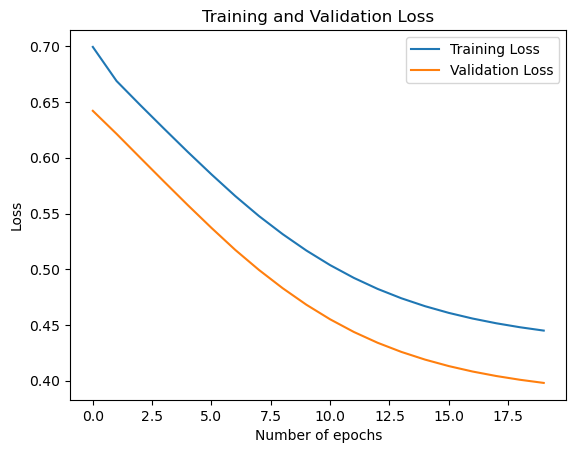

2024-07-31 17:23:36.588 | INFO     | src.training.evaluate:evaluate:46 - Neural Network – Empirical Risk Estimate: 0.4180831308788019, Accuracy: 0.764, F1 score: 0.40703517587939697, Precision: 0.262987012987013, Recall: 0.9, AUC: 0.8967155067155067
            Pred Neg  Pred Pos
Actual Neg       683       227
Actual Pos         9        81


Training complete.


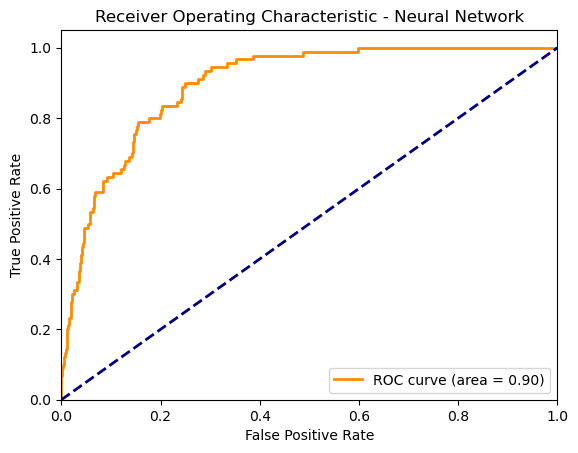

In [253]:
nn = BinaryNeuralNetwork(
    X_train_selected.shape[1],
    d_hidden,
    n_hidden,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)

nn.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected, plot=True)

y_pred = nn.predict(X_val_selected)
y_pred_proba = nn.predict_proba(X_val_selected)
R_est, acc, f1, auc = evaluate(
    "Neural Network", y_val_selected, y_pred, y_pred_proba, plot=True
)

The Neural Network that was trained with manually selected hyperparameters seems to perform well. The AUC score is > 0.999 and the F1 score is around 0.97. This is a great result. Let's see if we can get any better through automatic hyperparameter tuning.


### Automatic Hyperparameter Tuning


In [262]:
param_grid_nn = {
    "n_features": [X_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.1, 0.01, 0.001],
    "n_hidden_units": [16, 32, 64],
    "n_hidden_layers": [1, 2],
}

Empirical risk estimate for fold 1 / 5, parameter set 1 / 162: 0.46561968811063215
Empirical risk estimate for fold 1 / 5, parameter set 2 / 162: 0.49657779315103107
Empirical risk estimate for fold 1 / 5, parameter set 3 / 162: 0.4702823766006057
Empirical risk estimate for fold 1 / 5, parameter set 4 / 162: 0.5038229632046526
Empirical risk estimate for fold 1 / 5, parameter set 5 / 162: 0.4725407503591818
Empirical risk estimate for fold 1 / 5, parameter set 6 / 162: 0.4967737552430474
Empirical risk estimate for fold 1 / 5, parameter set 7 / 162: 0.4348293394485998
Empirical risk estimate for fold 1 / 5, parameter set 8 / 162: 0.4391252582880679
Empirical risk estimate for fold 1 / 5, parameter set 9 / 162: 0.43517932844694224
Empirical risk estimate for fold 1 / 5, parameter set 10 / 162: 0.4354988511240665
Empirical risk estimate for fold 1 / 5, parameter set 11 / 162: 0.43436162866170325
Empirical risk estimate for fold 1 / 5, parameter set 12 / 162: 0.43704865198475873
Empirica

2024-07-31 18:20:06.088 | INFO     | src.training.evaluate:evaluate:46 - Binary Neural Network – Empirical Risk Estimate: 0.41019208842472915, Accuracy: 0.775, F1 score: 0.43609022556390975, Precision: 0.29, Recall: 0.8787878787878788, AUC: 0.8899987668023184
            Pred Neg  Pred Pos
Actual Neg       688       213
Actual Pos        12        87


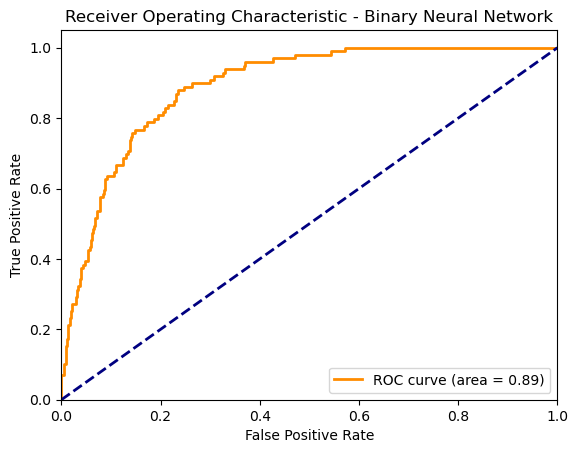

Empirical risk estimate on outer validation set: 0.41019208842472915
Epoch 0: Train Loss: 0.6351399555236348, Val Loss: 0.5760182095044049
Epoch 1: Train Loss: 0.5341486855618424, Val Loss: 0.49358225999602817
Epoch 2: Train Loss: 0.4728954094285717, Val Loss: 0.4526983305904937
Epoch 3: Train Loss: 0.4463713574200962, Val Loss: 0.43673198398423246
Epoch 4: Train Loss: 0.4361259968683589, Val Loss: 0.4303543026604062
Epoch 5: Train Loss: 0.4319578025928621, Val Loss: 0.42754117871283814
Epoch 6: Train Loss: 0.43002077340015465, Val Loss: 0.4260858256474583
Epoch 7: Train Loss: 0.429007908862473, Val Loss: 0.4252540136929508
Epoch 8: Train Loss: 0.4284360135340521, Val Loss: 0.42473118335479815
Epoch 9: Train Loss: 0.42809782411301284, Val Loss: 0.4243664152260572
Epoch 10: Train Loss: 0.4278807514124793, Val Loss: 0.4241242611963784
Epoch 11: Train Loss: 0.42774323479970044, Val Loss: 0.4239384497781259
Epoch 12: Train Loss: 0.4276552031122311, Val Loss: 0.42380736720821294
Epoch 13: T

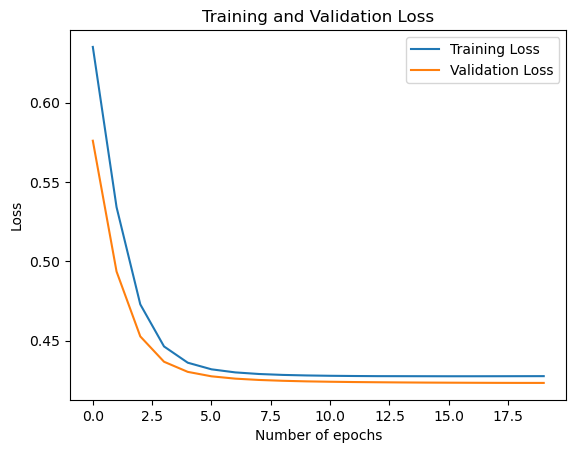

Training complete.
Fitted final model on entire dataset


In [263]:
k = 5

nn_final, nn_params, nn_R_est, nn_acc, nn_f1, nn_auc = select_model(
    X_selected,
    y_selected,
    BinaryNeuralNetwork,
    param_grid_nn,
    k=k,
)

We managed to achieve a perfect model! The AUC is 1.0, which is the best possible result. The precision is 1.0, which means the model is never wrong when it predicts a positive class. The recall is 1.0, which means the model is able to correctly classify all positive cases.

This implies that the Neural Network is slightly better at seperating the data than the Logistic Regression model. This also implies that there are non-linear relationships in the data that the polynomial features were not fully able to capture.


Finally, let's make predictions on the test data and store them as a CSV file to submit.


In [264]:
y_pred_final = nn_final.predict_proba(X_test_selected)

# save predictions as csv in the format id,stroke
path_predictions = "data/predictions.csv"
predictions = pd.DataFrame({"id": test_ids, "stroke": y_pred_final})
predictions.to_csv(base_path / path_predictions, index=False)

## Conclusion <a id="7"></a>
